<a href="https://colab.research.google.com/github/E-Fung/Classification_PCD/blob/main/PCD_Model_Creation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INITIALIZE LIBRARIES AND MODEL NAMES**

In [1]:
#########################################################################################################################################################################
#   Initialize libraries and such
#########################################################################################################################################################################

%tensorflow_version 2.x  # this line is not required unless you are in a notebook
from __future__ import absolute_import, division, print_function, unicode_literals
from mpl_toolkits.mplot3d import Axes3D
from google.colab import files
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import io
import os

# Print versions
!python --versions
print('Numpy ' + np.__version__)
print('TensorFlow ' + tf.__version__)
print('Keras ' + tf.keras.__version__)

tflite_model_name = 'PCD_Model'
c_model_name = 'PCD_Model'

#This is for gathering the metrics (accuracy % loss) for another set of values
class AdditionalValidationSets(tf.keras.callbacks.Callback):
    def __init__(self, validation_sets, verbose=0, batch_size=None):
        """
        :param validation_sets:
        a list of 3-tuples (validation_data, validation_targets, validation_set_name)
        or 4-tuples (validation_data, validation_targets, sample_weights, validation_set_name)
        :param verbose:
        verbosity mode, 1 or 0
        :param batch_size:
        batch size to be used when evaluating on the additional datasets
        """
        super(AdditionalValidationSets, self).__init__()
        self.validation_sets = validation_sets
        for validation_set in self.validation_sets:
            if len(validation_set) not in [3, 4]:
                raise ValueError()
        self.epoch = []
        self.history = {}
        self.verbose = verbose
        self.batch_size = batch_size

    def on_train_begin(self, logs=None):
        self.epoch = []
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epoch.append(epoch)

        # record the same values as History() as well
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        # evaluate on the additional validation sets
        for validation_set in self.validation_sets:
            if len(validation_set) == 3:
                validation_data, validation_targets, validation_set_name = validation_set
                sample_weights = None
            elif len(validation_set) == 4:
                validation_data, validation_targets, sample_weights, validation_set_name = validation_set
            else:
                raise ValueError()

            results = self.model.evaluate(x=validation_data,
                                          y=validation_targets,
                                          verbose=self.verbose,
                                          sample_weight=sample_weights,
                                          batch_size=self.batch_size)

            for metric, result in zip(self.model.metrics_names,results):
                valuename = validation_set_name + '_' + metric
                self.history.setdefault(valuename, []).append(result)

#########################################################################################################################################################################

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # this line is not required unless you are in a notebook`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
unknown option --versions
usage: python3 [option] ... [-c cmd | -m mod | file | -] [arg] ...
Try `python -h' for more information.
Numpy 1.19.5
TensorFlow 2.4.1
Keras 2.4.0


# **UPLOADING DATA**

In [2]:
#########################################################################################################################################################################
#   Uploading Files
#########################################################################################################################################################################
data_arr = ['data_n01','data_n02','data_n03','data_n04','data_n05','data_n06','data_n07','data_n08','data_n09','data_n10']
file_name = data_arr
#Change this to the name of the csv file you are uploading
uploaded = files.upload()
#########################################################################################################################################################################

Saving data_n01.csv to data_n01.csv
Saving data_n02.csv to data_n02.csv
Saving data_n03.csv to data_n03.csv
Saving data_n04.csv to data_n04.csv
Saving data_n05.csv to data_n05.csv
Saving data_n06.csv to data_n06.csv
Saving data_n07.csv to data_n07.csv
Saving data_n08.csv to data_n08.csv
Saving data_n09.csv to data_n09.csv
Saving data_n10.csv to data_n10.csv


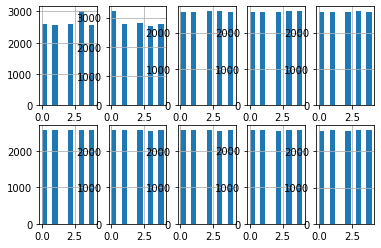

In [ ]:
#Verify that the data files are unique and have around the same data for each posture
data_arr = ['data_n01','data_n02','data_n03','data_n04','data_n05','data_n06','data_n07','data_n08','data_n09','data_n10']
dd1 = 'data_n01'
dd2 = 'data_n02'
dd3 = 'data_n03'
dd4 = 'data_n04'
dd5 = 'data_n05'
dd6 = 'data_n06'
dd7 = 'data_n07'
dd8 = 'data_n08'
dd9 = 'data_n09'
dd10 = 'data_n10'
imp_dd1 = pd.read_csv(dd1+'.csv')
imp_dd2 = pd.read_csv(dd2+'.csv')
imp_dd3 = pd.read_csv(dd3+'.csv')
imp_dd4 = pd.read_csv(dd4+'.csv')
imp_dd5 = pd.read_csv(dd5+'.csv')
imp_dd6 = pd.read_csv(dd6+'.csv')
imp_dd7 = pd.read_csv(dd7+'.csv')
imp_dd8 = pd.read_csv(dd8+'.csv')
imp_dd9 = pd.read_csv(dd9+'.csv')
imp_dd10 = pd.read_csv(dd10+'.csv')
plt.subplot(2,5,1)
imp_dd1.Class.hist()
plt.subplot(2,5,2)
imp_dd2.Class.hist()
plt.subplot(2,5,3)
imp_dd3.Class.hist()
plt.subplot(2,5,4)
imp_dd4.Class.hist()
plt.subplot(2,5,5)
imp_dd5.Class.hist()
plt.subplot(2,5,6)
imp_dd6.Class.hist()
plt.subplot(2,5,7)
imp_dd7.Class.hist()
plt.subplot(2,5,8)
imp_dd8.Class.hist()
plt.subplot(2,5,9)
imp_dd9.Class.hist()
plt.subplot(2,5,10)
imp_dd10.Class.hist()

# **DATA PROCESSING**

In [3]:
#########################################################################################################################################################################
#   This block of code is for processing the data, made into a function to implement n-fold cross validation
#########################################################################################################################################################################

def get_data(i,Relative_IMU,data_arr_val,ALL_BOOL,train_row_increments,test_row_increments):

  #Initialize variables
  test_data = data_arr_val[i]
  print("Testing Data: "+test_data)
  train_data_combined = pd.DataFrame()

  if ALL_BOOL:
    if len(data_arr_val)>1:
      data_arr_val.remove(data_arr_val[i])

  for data_itr in range(0,len(data_arr_val)):
    temp_data = pd.read_csv(data_arr_val[data_itr]+'.csv')
    train_data_combined = pd.concat([train_data_combined,temp_data],ignore_index=True)

  #Rearrange the data such that all IMUs share the "same" orientation, this allows us to try feeding relative IMU angles instead of raw IMU angles
  if Relative_IMU:
    temp = train_data_combined['x1']
    train_data_combined['x1'] = train_data_combined['y1']*-1
    train_data_combined['y1'] = temp
    temp = train_data_combined['x2']
    train_data_combined['x2']=train_data_combined['y2']
    train_data_combined['y2']=temp
    train_data_combined['x1'] = train_data_combined['x1']-train_data_combined['x3']
    train_data_combined['y1'] = train_data_combined['y1']-train_data_combined['y3']
    train_data_combined['z1'] = train_data_combined['z1']-train_data_combined['z3']
    train_data_combined['x2'] = train_data_combined['x2']-train_data_combined['x3']
    train_data_combined['y2'] = train_data_combined['y2']-train_data_combined['y3']
    train_data_combined['z2'] = train_data_combined['z2']-train_data_combined['z3']
    train_data_combined['x3'] = train_data_combined['x3']-train_data_combined['x4']
    train_data_combined['y3'] = train_data_combined['y3']-train_data_combined['y4']
    train_data_combined['z3'] = train_data_combined['z3']-train_data_combined['z4']

  #Process the data::
  train_data_sampled = train_data_combined[1::train_row_increments]#sample every few rows to improve training data (IMUs give data very frequently so the data is very similar)
  data_shuffled = train_data_sampled.sample(frac=1).reset_index(drop=True)#shuffle it
  d0 = data_shuffled.loc[data_shuffled['Class'] == 0]#split the data by their posture, the data remains ordered (post shuffle)
  d1 = data_shuffled.loc[data_shuffled['Class'] == 1]
  d2 = data_shuffled.loc[data_shuffled['Class'] == 2]
  d3 = data_shuffled.loc[data_shuffled['Class'] == 3]
  d4 = data_shuffled.loc[data_shuffled['Class'] == 4]
  min_class = min(len(d0),len(d1),len(d2),len(d3),len(d4))
  d0_split = d0.sample(frac=(min_class/len(d0)),random_state=1) #slice so that all postures have same number of data entries
  d1_split = d1.sample(frac=(min_class/len(d1)),random_state=1) 
  d2_split = d2.sample(frac=(min_class/len(d2)),random_state=1) 
  d3_split = d3.sample(frac=(min_class/len(d3)),random_state=1) 
  d4_split = d4.sample(frac=(min_class/len(d4)),random_state=1) 
  data_final_combine = pd.concat([d0_split,d1_split,d2_split,d3_split,d4_split],ignore_index=True)#combine them
  data_processed = data_final_combine.sample(frac=1).reset_index(drop=True)#shuffle again
  posture_processed = data_processed.pop('Class')
  data_processed = data_processed/180 #you want the data to be between -1 and 1, the IMU code restricts the angles between 180 and -180

  global x_val,x_train,y_val,y_train,x_val_test,y_val_test

  #Split the data into 2 sets:: Training and Validation(used to check against overfitting, you dont want training accuracy to be over validation) 
  val_ratio = 0.25    # Percentage of samples that should be held for validation set
  length_data_processed = data_processed.shape[0]
  val_split = int(val_ratio * length_data_processed)
  x_val, x_train = np.split(data_processed, [val_split])
  y_val, y_train = np.split(posture_processed, [val_split])
  assert(x_train.size + x_val.size) == data_processed.size

  if ALL_BOOL:
    x_val_test = x_val
    y_val_test = y_val
  else:
    #Process the data for the testing data (This will be data from a new user that has never had their data in the training set)
    x_val_test = pd.read_csv(test_data+'.csv')
    x_val_test = x_val_test[1::test_row_increments]
    x_val_test = x_val_test.sample(frac=1).reset_index(drop=True)
    y_val_test = x_val_test.pop('Class')
    x_val_test = x_val_test/ 180

  #Rearrange the data
  if Relative_IMU:
    temp = x_val_test['x1']
    x_val_test['x1'] = x_val_test['y1']*-1
    x_val_test['y1'] = temp
    temp = x_val_test['x2']
    x_val_test['x2']=x_val_test['y2']
    x_val_test['y2']=temp
    x_val_test['x1'] = x_val_test['x1']-x_val_test['x3']
    x_val_test['y1'] = x_val_test['y1']-x_val_test['y3']
    x_val_test['z1'] = x_val_test['z1']-x_val_test['z3']
    x_val_test['x2'] = x_val_test['x2']-x_val_test['x3']
    x_val_test['y2'] = x_val_test['y2']-x_val_test['y3']
    x_val_test['z2'] = x_val_test['z2']-x_val_test['z3']
    x_val_test['x3'] = x_val_test['x3']-x_val_test['x4']
    x_val_test['y3'] = x_val_test['y3']-x_val_test['y4']
    x_val_test['z3'] = x_val_test['z3']-x_val_test['z4']
#########################################################################################################################################################################

# **MODEL CREATION**

1 out of 1 runs
Testing Data: data_n01
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 35)                455       
_________________________________________________________________
dropout (Dropout)            (None, 35)                0         
_________________________________________________________________
Layer_2 (Dense)              (None, 35)                1260      
_________________________________________________________________
dropout_1 (Dropout)          (None, 35)                0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 180       
Total params: 1,895
Trainable params: 1,895
Non-trainable params: 0
_______________

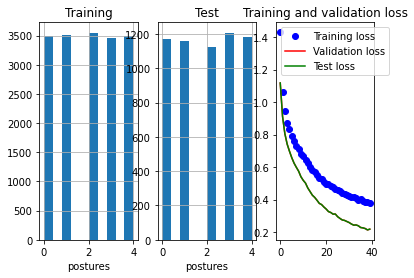

183/183 - 0s - loss: 0.2174 - accuracy: 0.9409

Test accuracy: 0.9409246444702148


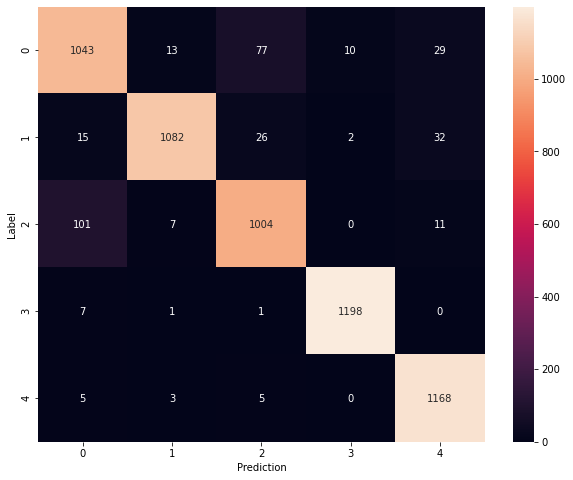

In [4]:
#########################################################################################################################################################################
#   This block of code is for trying different model configurations and seeing what works best
#########################################################################################################################################################################

Save_Performance = False
Custom_Learn_Rate = False
Verbose = 2 
Visualize = True
Relative_IMU = False
ALL_BOOL = True

#Affects the range of layers that the models will have and how much times we want to test that setup
layer_1_itr = 1       #how many different first layer sizes to try
layer_2_itr = 1       #how many different second layer sizes to try
test_per_config = 1   #how many times we want to test one model spec *(use multiple of total datasets)*

hidden_layer_1 = 35
hidden_layer_2 = 35
hidden_layer_1_interval = 5
hidden_layer_2_interval = 5

starting_num_epochs = 40
run_offset = 0

dropout_percent = 0.2
callback_patience = 4
decay_rate = 0.90
decay_steps = 200

saved_metric_name = 'Single_Lower_IMU' #A file under this name will be saved containing the performance of different model configurations
saved_acc_name = 'Acc_'+saved_metric_name
# data_arr = ['data_G01','data_01','data_b01']
# data_arr = ['data_01','data_b01','data_b02','data_b03','data_b05','data_G01','data_G02','data_02']
data_arr = ['data_n01','data_n02','data_n03','data_n04','data_n05','data_n06','data_n07','data_n08','data_n09','data_n10']
total_datasets = len(data_arr)

#Change these
train_row_increments = 5
test_row_increments = 5
#########################################################################################################################################################################

#Only for telling us how much more models will be tested
curr_run = 1
total_run = layer_1_itr*layer_2_itr*test_per_config 

test_history = pd.DataFrame(columns=['Accuracy','Layer 1','Layer 2','Dropout %','Average of','Patience','IN Learning Rate','decay_rate','decay_steps','Relative_IMU'])#stores performance stats
acc_history = pd.DataFrame(columns=['Run','Accuracy','Layer 1','Layer 2','Dropout %','Average of','Patience','IN Learning Rate','decay_rate','decay_steps','Relative_IMU'])
for i in range(0,layer_1_itr):
  for j in range(0,layer_2_itr):
    average_accuracy = 0;
    for k in range(0,test_per_config):

      #Print out which loop we are undergoing
      DATA_ARR = data_arr.copy()
      print(str(curr_run)+" out of "+str(total_run) + " runs")
      get_data((curr_run-1)%total_datasets+run_offset,Relative_IMU,DATA_ARR,ALL_BOOL,train_row_increments,test_row_increments)

      if Visualize: #to verify data being passed through looks good
        plt.subplot(1,3,1)
        y_train.hist() #displays the histogram based on posture
        plt.title("Training")
        plt.xlabel('postures')
        plt.subplot(1,3,2)
        y_val_test.hist()
        plt.title("Test")
        plt.xlabel('postures')

      initial_learning_rate = (hidden_layer_1+i*hidden_layer_1_interval)/10000

      #Creates the model structure and chooses the activation function for each layer
      model = tf.keras.Sequential([                      
          tf.keras.layers.Flatten(input_shape=(12,1)),
          tf.keras.layers.Dense(hidden_layer_1+i*hidden_layer_1_interval, activation='relu', name= "Layer_1",kernel_initializer='random_normal'),  #hidden layers are generally: relu, sigmoid, tanh (Usually constant for all hidden layers)
          tf.keras.layers.Dropout(dropout_percent), #dropouts only occur during training
          tf.keras.layers.Dense(hidden_layer_2+j*hidden_layer_2_interval, activation='relu', name= "Layer_2",kernel_initializer='random_normal'),  
          tf.keras.layers.Dropout(dropout_percent),
          tf.keras.layers.Dense(5, activation='linear', name= "Predicted_Posture"), #output layers are generally: linear, sigmoid, softmax
      ])

      if Visualize:
        model.summary()

      #Stops the model training early to prevent overfitting
      callbacks = [
      tf.keras.callbacks.EarlyStopping(# Stop training when `val_loss` is no longer improving
          monitor="val_accuracy",
          # min_delta=callback_delta,
          mode='auto',
          patience=callback_patience,# "no longer improving" being further defined as "for at least x epochs"
          verbose=1,
        )
      ] 

      #Adds the x_val dataset to be tested 
      val_test = AdditionalValidationSets([(x_val, y_val, 'val2')])

      #Saves the models when the accuracy is pred_post based on the test values
      temp_str = str(curr_run)
      while len(temp_str) < len(str(total_run)):
        temp_str = str(0)+temp_str 
      checkpoint_path = "training_"+temp_str+"/cp.ckpt"
      checkpoint_dir = os.path.dirname(checkpoint_path)
      cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, monitor="val_accuracy",mode= "auto",save_best_only=True,save_weights_only=True,verbose=Verbose)

      #Assign type of: optimizer, loss, and metric
      lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=decay_steps, decay_rate=decay_rate, staircase=True)
      opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
      model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

      #Train the model with the training data and save the stats in history
      history = model.fit(x_train,y_train,epochs=starting_num_epochs,callbacks = [val_test,callbacks,cp_callback],validation_data=(x_val_test, y_val_test),shuffle = True, verbose= Verbose)

      if Visualize:#Plots the training vs validation loss
        loss = history.history['loss']
        test_loss = history.history['val_loss']
        val_loss = val_test.history['val2_loss']
        epochs = history.epoch
        plt.subplot(1,3,3)
        plt.plot(epochs, loss, 'bo', label='Training loss')
        plt.plot(epochs, val_loss, 'r', label='Validation loss')
        plt.plot(epochs, test_loss, 'g', label='Test loss')
        plt.title('Training and validation loss')
        plt.legend()
        plt.show()

      
      test_loss, test_acc = model.evaluate(x_val_test,  y_val_test, verbose=Verbose)
      if Verbose!=0: #Test the model with unseen data and record the settings
        print('\nTest accuracy:', test_acc)

      if Visualize:
        #create a confusion matrix to see model performance
        predictions = model.predict(x_val_test)
        predictions = np.argmax(predictions,axis = 1)
        confusion_mtx = tf.math.confusion_matrix(
            y_val_test, predictions, 5, weights=None, dtype=tf.dtypes.int32,
            name='PCD_Confusion_Matrix'
        )
        plt.figure(figsize=(10, 8))
        sns.heatmap(confusion_mtx,annot=True, fmt='g')
        plt.xlabel('Prediction')
        plt.ylabel('Label')
        plt.show()
      average_accuracy = average_accuracy + test_acc
      acc_row = {'Run':(curr_run-1)%total_datasets,'Accuracy':test_acc,'Layer 1':hidden_layer_1+i*hidden_layer_1_interval,'Layer 2':hidden_layer_2+j*hidden_layer_2_interval,'Dropout %':dropout_percent,
               'Average of':test_per_config,'Patience':callback_patience,'IN Learning Rate':initial_learning_rate,'decay_rate':decay_rate,'decay_steps':decay_steps,'Relative_IMU':Relative_IMU}
      acc_history = acc_history.append(acc_row, ignore_index=True)
      curr_run += 1

    #Records the test results for specific model configuration
    average_accuracy = average_accuracy/test_per_config
    new_row = {'Accuracy':average_accuracy,'Layer 1':hidden_layer_1+i*hidden_layer_1_interval,'Layer 2':hidden_layer_2+j*hidden_layer_2_interval,'Dropout %':dropout_percent,
               'Average of':test_per_config,'Patience':callback_patience,'IN Learning Rate':initial_learning_rate,'decay_rate':decay_rate,'decay_steps':decay_steps,'Relative_IMU':Relative_IMU}
    test_history = test_history.append(new_row, ignore_index=True)

#Saves performance data
if Save_Performance:
  test_history.to_csv(saved_metric_name+".csv",index=False)
  from google.colab import files
  files.download(saved_metric_name+".csv")
  acc_history.to_csv(saved_acc_name+".csv",index=False)
  from google.colab import files
  files.download(saved_acc_name+".csv")
#########################################################################################################################################################################

In [ ]:
##downloads the file should we want it
test_history.to_csv(saved_metric_name+".csv",index=False)
from google.colab import files
files.download(saved_metric_name+".csv")
acc_history.to_csv(saved_acc_name+".csv",index=False)
from google.colab import files
files.download(saved_acc_name+".csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **TESTING THRESHOLDS**

In [5]:
#########################################################################################################################################################################
#   Load specific model
#########################################################################################################################################################################
model_name = "training_1"
model.load_weights(model_name + "/cp.ckpt")
#########################################################################################################################################################################

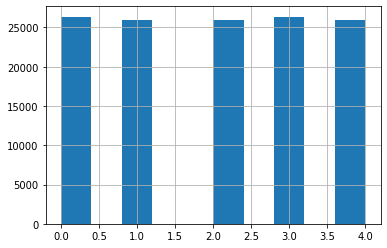

In [6]:
#########################################################################################################################################################################
#   Combines all the datasets
#########################################################################################################################################################################
  
data_arr = ['data_n01','data_n02','data_n03','data_n04','data_n05','data_n06','data_n07','data_n08','data_n09','data_n10']
test_data_01 = data_arr[0]
test_data_02 = data_arr[1]
test_data_03 = data_arr[2]
test_data_04 = data_arr[3]
test_data_05 = data_arr[4]
test_data_06 = data_arr[5]
test_data_07 = data_arr[6]
test_data_08 = data_arr[7]
test_data_09 = data_arr[8]
test_data_10 = data_arr[9]

#Initialize dataframes for storing the data and combine them 
test_data1 = pd.read_csv(test_data_01+'.csv')
test_data2 = pd.read_csv(test_data_02+'.csv')
test_data3 = pd.read_csv(test_data_03+'.csv')
test_data4 = pd.read_csv(test_data_04+'.csv')
test_data5 = pd.read_csv(test_data_05+'.csv')
test_data6 = pd.read_csv(test_data_06+'.csv')
test_data7 = pd.read_csv(test_data_07+'.csv')
test_data8 = pd.read_csv(test_data_08+'.csv')
test_data9 = pd.read_csv(test_data_09+'.csv')
test_data10 = pd.read_csv(test_data_10+'.csv')

test_data_combined = pd.concat([test_data1,test_data2,test_data3,test_data4,test_data5,test_data6,test_data7,test_data8,test_data9,test_data10],ignore_index=True)
test_data_combined = test_data_combined[1::1]
test_data_combined = pd.concat([test_data_combined],ignore_index=True)
test_data_combined.Class.hist()

test_label = test_data_combined.pop("Class")

inc = -40
test_data_combined['x1'] -= inc
test_data_combined['x2'] -= inc
test_data_combined['x3'] -= inc
test_data_combined['x4'] -= inc



test_data_combined = test_data_combined/180


if Relative_IMU:
  temp = test_data_combined['x1']
  test_data_combined['x1'] = test_data_combined['y1']*-1
  test_data_combined['y1'] = temp
  temp = test_data_combined['x2']
  test_data_combined['x2']=test_data_combined['y2']
  test_data_combined['y2']=temp
  test_data_combined['x1'] = test_data_combined['x1']-test_data_combined['x3']
  test_data_combined['y1'] = test_data_combined['y1']-test_data_combined['y3']
  test_data_combined['z1'] = test_data_combined['z1']-test_data_combined['z3']
  test_data_combined['x2'] = test_data_combined['x2']-test_data_combined['x3']
  test_data_combined['y2'] = test_data_combined['y2']-test_data_combined['y3']
  test_data_combined['z2'] = test_data_combined['z2']-test_data_combined['z3']
  test_data_combined['x3'] = test_data_combined['x3']-test_data_combined['x4']
  test_data_combined['y3'] = test_data_combined['y3']-test_data_combined['y4']
  test_data_combined['z3'] = test_data_combined['z3']-test_data_combined['z4']
#########################################################################################################################################################################

In [7]:
#########################################################################################################################################################################
#   Softmax Function Definition
#########################################################################################################################################################################

def softmax(x):
    pred = np.empty((len(x),5),float)
    for i in range(0,len(x)):
      row = x[i:i+1];
      ex = np.exp(row)
      sum_ex = np.sum(np.exp(row))
      pred[i:i+1]=ex/sum_ex
    return pred

#########################################################################################################################################################################

[0.55 0.55 0.55 0.55 0.55]


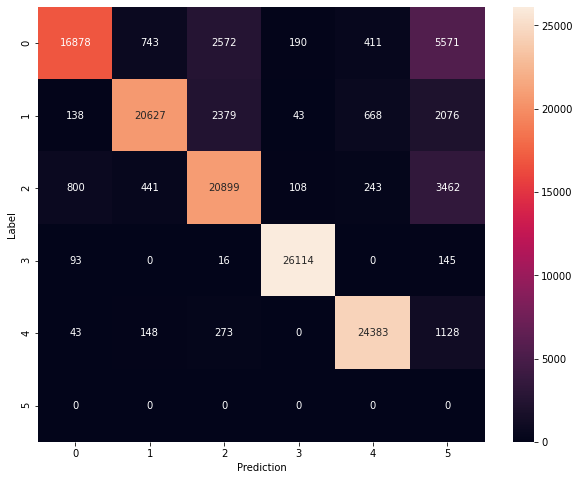

In [34]:
#########################################################################################################################################################################
#   Testing One Configuration of thresholds & priority sequence
#########################################################################################################################################################################

Verification_File_Name = "Model_Verification_Final_50"
save_threshold_data = False

PRINT_CON = True
predictions = model.predict(test_data_combined)
predictions = softmax(predictions)
# predictions = predictions[0:5]
permu_len = 1
only_perm = [1,5,4,2,3]

log_loss_history = pd.DataFrame(columns=['Log Loss','Priority','Threshold','Accuracy','No Posture Rate','Active Accuracy','Confusion Mat'])#stores performance stats

#Cycle between different threshold values
min_thres = 0.50
max_thres = 0.50
inc_thres = 0.05

curr_thres = np.array([0.55,0.55,0.55,0.55,0.55])

pred_len = len(predictions)
# test_label = test_label[0:5]
total_true = test_label

#Loop through all thresholding values

print(curr_thres)
#Loop through all permutations of [1,2,3,4,5] priority
con_mat = np.zeros((6,6))
curr_perm = only_perm
# curr_perm = all_permu[perm_itr]
curr_log_loss = 0

#Loop through all prediction values
for pred_itr in range(0,pred_len):
  curr_pred = np.array(predictions[pred_itr:pred_itr+1])
  passed_thres = np.array([0,0,0,0,0])
  passed_thres = np.greater_equal(curr_pred,curr_thres)
  passed_thres = passed_thres *curr_perm
  pred_post = np.amax(passed_thres)
  true_post = total_true[pred_itr]
  estimated_post = 10
  if pred_post: #if the pred_post exist then update the con_mat
    estimated_post = curr_perm.index(pred_post)
    con_mat[true_post][estimated_post] +=1 
    probability_estimate = curr_pred[0][estimated_post]
  else: #no posture is detected, increment accordingly
    con_mat[true_post][5] +=1 
  probability_true = curr_pred[0][true_post]
  if estimated_post == true_post:#if the model was correct
    add_log = math.log10(probability_estimate)*-1
    curr_log_loss += (add_log)
  else:
    add_log = math.log10(1-probability_true)*-1
    curr_log_loss += (add_log)
if PRINT_CON:
  plt.figure(figsize=(10, 8))
  sns.heatmap(con_mat,annot=True, fmt='g')
  plt.xlabel('Prediction')
  plt.ylabel('Label')
  plt.show()
  acc = sum(np.diagonal(con_mat))/pred_len
  no_post_rate = sum(con_mat[:,5])/pred_len
  act_acc = sum(np.diagonal(con_mat))/(pred_len-sum(con_mat[:,5]))
  # print("Log Loss: "+str(curr_log_loss)+"  Threshold: "+str(curr_thres)+"   Active Accuracy: "+str(act_acc)+"   no post rate: "+str(no_post_rate)+" Confusion Matrix: "+str(con_mat))
  new_row = ({'Log Loss':curr_log_loss,'Priority':curr_perm,'Threshold':curr_thres+0,'Accuracy':acc,'No Posture Rate':no_post_rate,'Active Accuracy':act_acc,'Confusion Mat':con_mat})


  log_loss_history = log_loss_history.append(new_row, ignore_index=True)    

#save the file
if save_threshold_data:
  log_loss_history.to_csv(Verification_File_Name+".csv",index=False)
  from google.colab import files
  files.download(Verification_File_Name+".csv")

#########################################################################################################################################################################

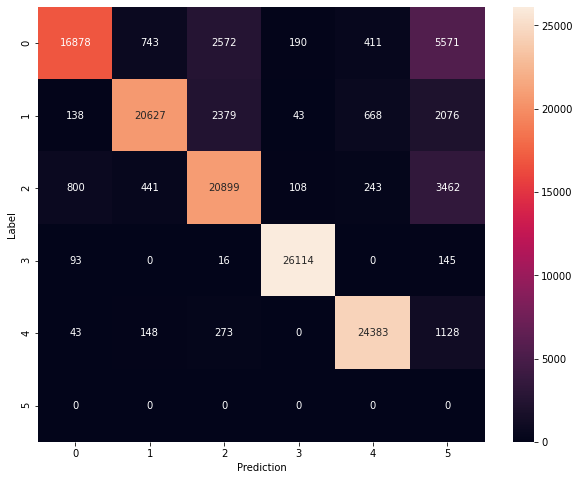

4081/4081 - 4s - loss: 0.3376 - accuracy: 0.8841

Test accuracy: 0.8840664029121399


{'Accuracy': 0.8339025361431022,
 'Active Accuracy': 0.9212503172320446,
 'Confusion Mat': array([[1.6878e+04, 7.4300e+02, 2.5720e+03, 1.9000e+02, 4.1100e+02,
         5.5710e+03],
        [1.3800e+02, 2.0627e+04, 2.3790e+03, 4.3000e+01, 6.6800e+02,
         2.0760e+03],
        [8.0000e+02, 4.4100e+02, 2.0899e+04, 1.0800e+02, 2.4300e+02,
         3.4620e+03],
        [9.3000e+01, 0.0000e+00, 1.6000e+01, 2.6114e+04, 0.0000e+00,
         1.4500e+02],
        [4.3000e+01, 1.4800e+02, 2.7300e+02, 0.0000e+00, 2.4383e+04,
         1.1280e+03],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00]]),
 'Log Loss': 9486.732115310078,
 'No Posture Rate': 0.09481438372947806,
 'Priority': [1, 5, 4, 2, 3],
 'Threshold': array([0.55, 0.55, 0.55, 0.55, 0.55])}

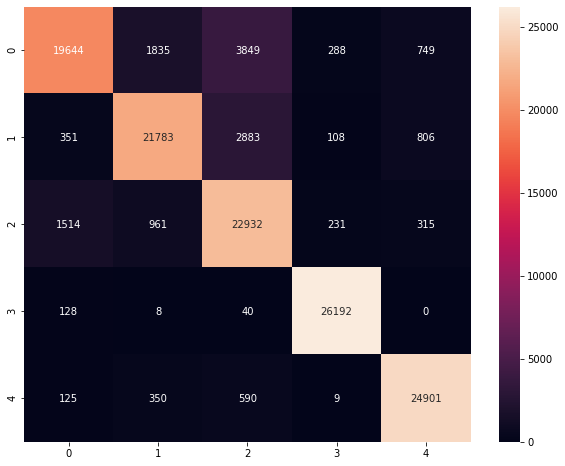

In [35]:
#########################################################################################################################################################################
#   Displays performance of latest priority-threshold filter vs that of having no filter
#########################################################################################################################################################################

#with final filter
plt.figure(figsize=(10, 8))
sns.heatmap(con_mat,annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

#without
test_loss, test_acc = model.evaluate(test_data_combined,  test_label, verbose=Verbose)
print('\nTest accuracy:', test_acc)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,annot=True, fmt='g')

#########################################################################################################################################################################

In [ ]:
#########################################################################################################################################################################
#   Testing Multiple Configuration of thresholds & priority sequence
#########################################################################################################################################################################

Verification_File_Name = "Model_Verification_Final_50"
save_threshold_data = True

PRINT_CON = False
predictions = model.predict(test_data_combined)
predictions = softmax(predictions)
# predictions = predictions[0:5]
import itertools  #Creates permutations of priority
all_permu = list(itertools.permutations([1,2,3,4,5]))
permu_len = len(all_permu)

log_loss_history = pd.DataFrame(columns=['Log Loss','Priority','Threshold','Accuracy','No Posture Rate','Active Accuracy','Confusion Mat'])#stores performance stats

#Cycle between different threshold values
min_thres = 0.40
max_thres = 0.70
inc_thres = 0.15

curr_thres = np.array([min_thres,min_thres,min_thres,min_thres,min_thres])

pred_len = len(predictions)
# test_label = test_label[0:5]
total_true = test_label

#Loop through all thresholding values
while curr_thres[0]<=max_thres:
  curr_thres[1] = min_thres
  while curr_thres[1]<=max_thres:
    curr_thres[2] = min_thres
    while curr_thres[2]<=max_thres:
      curr_thres[3] = min_thres
      while curr_thres[3]<=max_thres:
        curr_thres[4] = min_thres
        while curr_thres[4]<=max_thres:
          print(curr_thres)
          #Loop through all permutations of [1,2,3,4,5] priority
          for perm_itr in range (0,permu_len):
            con_mat = np.zeros((6,6))
            curr_perm = only_perm
            # curr_perm = all_permu[perm_itr]
            print("Curr perm:" +str(perm_itr+1))
            curr_log_loss = 0

            #Loop through all prediction values
            for pred_itr in range(0,pred_len):
              curr_pred = np.array(predictions[pred_itr:pred_itr+1])
              passed_thres = np.array([0,0,0,0,0])
              passed_thres = np.greater_equal(curr_pred,curr_thres)
              passed_thres = passed_thres *curr_perm
              pred_post = np.amax(passed_thres)
              true_post = total_true[pred_itr]
              estimated_post = 10
              if pred_post: #if the pred_post exist then update the con_mat
                estimated_post = curr_perm.index(pred_post)
                con_mat[true_post][estimated_post] +=1 
                probability_estimate = curr_pred[0][estimated_post]
              else: #no posture is detected, increment accordingly
                con_mat[true_post][5] +=1 
              probability_true = curr_pred[0][true_post]
              if estimated_post == true_post:#if the model was correct
                add_log = math.log10(probability_estimate)*-1
                curr_log_loss += (add_log)
              else:
                add_log = math.log10(1-probability_true)*-1
                curr_log_loss += (add_log)
            if PRINT_CON:
              plt.figure(figsize=(10, 8))
              sns.heatmap(con_mat,annot=True, fmt='g')
              plt.xlabel('Prediction')
              plt.ylabel('Label')
              plt.show()
            acc = sum(np.diagonal(con_mat))/pred_len
            no_post_rate = sum(con_mat[5])/pred_len
            act_acc = sum(np.diagonal(con_mat))/(pred_len-sum(con_mat[5]))
            # print("Log Loss: "+str(curr_log_loss)+"  Threshold: "+str(curr_thres)+"   Active Accuracy: "+str(act_acc)+"   no post rate: "+str(no_post_rate)+" Confusion Matrix: "+str(con_mat))
            new_row = ({'Log Loss':curr_log_loss,'Priority':curr_perm,'Threshold':curr_thres+0,'Accuracy':acc,'No Posture Rate':no_post_rate,'Active Accuracy':act_acc,'Confusion Mat':con_mat})


            log_loss_history = log_loss_history.append(new_row, ignore_index=True)    
          curr_thres[4] += inc_thres
        curr_thres[3] += inc_thres
      curr_thres[2] += inc_thres
    curr_thres[1] += inc_thres
  curr_thres[0] += inc_thres
#save the file
if save_threshold_data:
  log_loss_history.to_csv(Verification_File_Name+".csv",index=False)
  from google.colab import files
  files.download(Verification_File_Name+".csv")
#########################################################################################################################################################################

NameError: ignored

# **TESTING MODELS**


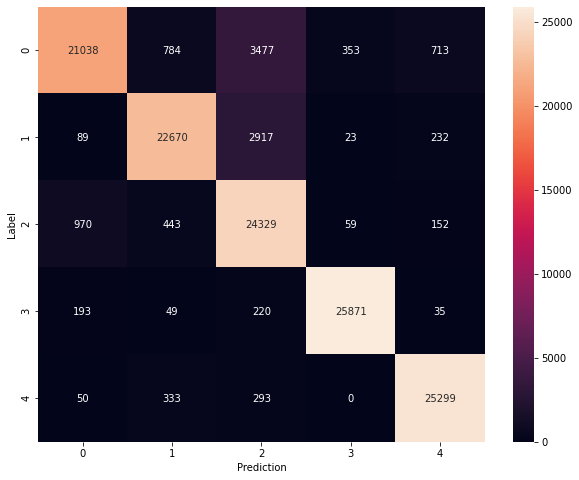

In [ ]:
predictions = model.predict(test_data_combined)
predictions = np.argmax(predictions,axis = 1)
confusion_mtx = tf.math.confusion_matrix(
    test_label, predictions, 5, weights=None, dtype=tf.dtypes.int32,
    name='PCD_Confusion_Matrix'
)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

*Select the specific traing_x model that you want to reload*


# **CONVERTING THE MODEL**

In [ ]:
#########################################################################################################################################################################
#   Function to convert tflite file to C header file
#########################################################################################################################################################################

# Function: Convert some hex value into an array for C programming
def hex_to_c_array(hex_data, var_name):

  c_str = ''

  # Create header guard
  c_str += '#ifndef ' + var_name.upper() + '_H\n'
  c_str += '#define ' + var_name.upper() + '_H\n\n'

  # Add array length at top of file
  c_str += '\nunsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

  # Declare C variable
  c_str += 'unsigned char ' + var_name + '[] = {'
  hex_array = []
  for i, val in enumerate(hex_data) :

    # Construct string from hex
    hex_str = format(val, '#04x')

    # Add formatting so each line stays within 80 characters
    if (i + 1) < len(hex_data):
      hex_str += ','
    if (i + 1) % 12 == 0:
      hex_str += '\n '
    hex_array.append(hex_str)

  # Add closing brace
  c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

  # Close out header guard
  c_str += '#endif //' + var_name.upper() + '_H'

  return c_str

#########################################################################################################################################################################

In [ ]:
#########################################################################################################################################################################
#   Load specific model
#########################################################################################################################################################################

model_name = "training_1"
model.load_weights(model_name + "/cp.ckpt")
#########################################################################################################################################################################

In [ ]:
#########################################################################################################################################################################
#   Optimize the model for size and convert to tflite model
#########################################################################################################################################################################

#Covert the model to a tflite model & optimize to reduce the size
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()
open(tflite_model_name + '.tflite', 'wb').write(tflite_model)

#########################################################################################################################################################################

INFO:tensorflow:Assets written to: /tmp/tmp98ilygof/assets


7808

In [ ]:
#########################################################################################################################################################################
#   Convert to c-header file via function
#########################################################################################################################################################################

# Write TFLite model to a C source (or header) file
with open(c_model_name + '.h', 'w') as file:
  file.write(hex_to_c_array(tflite_model, c_model_name))

#########################################################################################################################################################################